In [35]:
from tl import preprocess
from src import helperfuncs

import time
import os
from pathlib import Path
import numpy as np

start_time = time.time()

folderPath = 'C:/My Documents/TUD-MCL/Semester 4/Thesis/Implementation/Data/Dataset-1/'
imgName = '18_04_27_Thomas_28618_0016.dm3'

dirname = 'C:/My Documents/TUD-MCL/Semester 4/Thesis/repo/img-denoiser'
templatesPath = Path(dirname + "/data/" + 'alltemplates.pickle')

stride=3
templateSize=48

imgs = helperfuncs.loadData(folderPath, imgName)

allTemplates = preprocess.loadTemplates(imgs, stride, templateSize, templatesPath)

In [29]:
allTemplates = allTemplates[:,:,:,np.newaxis]
# np.random.shuffle(allTemplates)

maxVal = np.max(allTemplates)
allTemplates = allTemplates.astype("float32")/maxVal

train_len = int(np.floor(allTemplates.shape[0]*0.8))
train = allTemplates[:train_len,:,:,:]
test = allTemplates[train_len:,:,:,:]

print(allTemplates.shape)


(24025, 48, 48, 1)


In [30]:
from tl import tldenoise
from tensorflow import keras

try:
    autoencoder = keras.models.load_model('C:/My Documents/TUD-MCL/Semester 4/Thesis/repo/img-denoiser/model/model.h5')
    autoencoder.summary()
except IOError:
    print("No saved model found")
    autoencoder = tldenoise.buildModel()
    autoencoder.fit(
        x=train,
        y=train,
        epochs=100,
        batch_size=128,
        shuffle=True,
        validation_data=(test, test),
    )
    autoencoder.save('C:/My Documents/TUD-MCL/Semester 4/Thesis/repo/img-denoiser/model/model.h5')


No saved model found
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 48, 

In [31]:
print(allTemplates.shape)

predictions = autoencoder.predict(allTemplates[:,:,:,:])

predictions = predictions[:,:,:,:]*maxVal


(24025, 48, 48, 1)


(-0.5, 47.5, 47.5, -0.5)

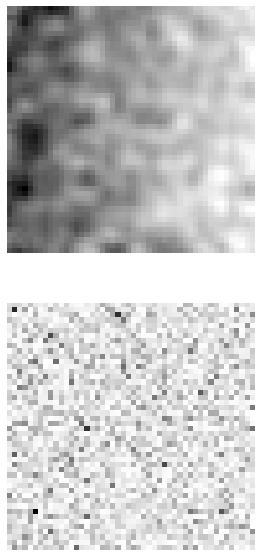

In [32]:
import matplotlib.pyplot as plt

predictions_disp = predictions[300,:,:,:]*maxVal

   
plt.figure(figsize=(5, 5*2)) 

vstd=np.std(predictions_disp)
vmean=np.mean(predictions_disp)         
ax1=plt.subplot(2,1,1)
ax1.imshow(predictions_disp,cmap='gray',vmin=np.min(predictions_disp),vmax=np.max(predictions_disp))
ax1.axis('off')

disp = test[0,:,:,:]*maxVal

vstd=np.std(test)
vmean=np.mean(disp)         
ax1=plt.subplot(2,1,2)
ax1.imshow(disp,cmap='gray',vmin=np.min(disp),vmax=np.max(disp))
ax1.axis('off')


In [33]:
# generating a smooth transistion map:
backplotwindow=np.zeros((templateSize, templateSize))
x = np.linspace(0, 1, backplotwindow.shape[0])
y = np.linspace(0, 1,  backplotwindow.shape[1])
xv, yv = np.meshgrid(x, y, sparse=True)
backplotwindow=np.exp(-((4*np.maximum(0,(xv-0.5))**2-0.1)+(4*np.maximum(0,(yv-0.5))**2-0.1)))   


# n=0
# pltminradius=3

    
overlay=[]
overlayCount=[]
overlayclass=[]

for i in range(len(imgs)):
    img = imgs[i]
    overlay.append(np.zeros(img.shape))
    overlayCount.append(np.zeros(img.shape))

n=0

for o in range(0,len(overlay)):
    for x in range(0, imgs[o].shape[0]-templateSize, stride):
        for y in range(0, imgs[o].shape[1]-templateSize, stride):
            predicted_template = predictions[n,:,:,0]
            overlay[o][x:(x+templateSize),y:(y+templateSize)]+=predicted_template*backplotwindow
            overlayCount[o][x:(x+templateSize),y:(y+templateSize)]+=backplotwindow
            n+=1
            
imgBackplots = []
mymin=[]
mymax=[]
for i in range(len(imgs)):
    imgBackplots.append(overlay[i]/ ( overlayCount[i] + (np.double(overlayCount[i]==0))  ) ) 
    mymin.append(np.min(imgBackplots[i][imgBackplots[i]>np.min(imgBackplots[i][imgBackplots[i]>0])]))
    mymax.append(np.max(imgBackplots[i][imgBackplots[i]>0]))



(512, 512)


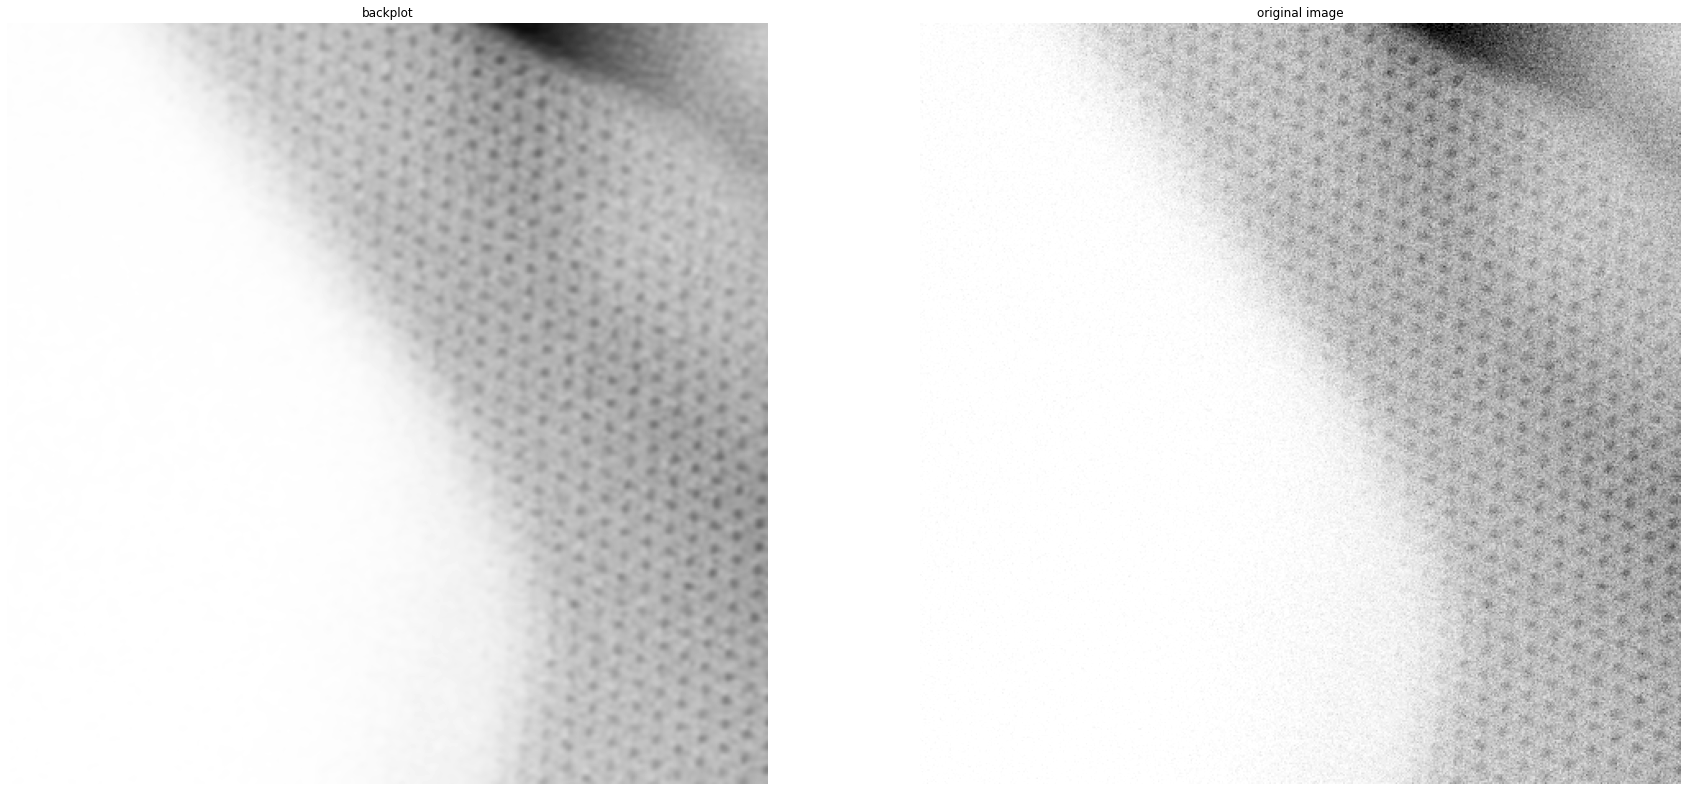

In [34]:
for i in range(len(imgs)):
    print(imgBackplots[i].shape)
    radius = templateSize//2
    plt.figure(figsize=(2*15, 2*7)) 
    ax1=plt.subplot(1,2,1)                    
    ax1.imshow(imgBackplots[i][radius:-radius,radius:-radius],cmap=plt.cm.gray,vmin=mymin[i],vmax=mymax[i])
    ax1.set_title('backplot')
    ax1.axis('off')
    ax2=plt.subplot(1,2,2)                    
    ax2.imshow(imgs[i][radius:-radius,radius:-radius],cmap=plt.cm.gray,vmin=mymin[i],vmax=mymax[i])
    ax2.set_title('original image')
    ax2.axis('off')
    #plt.figure(figsize=(15, 12))  
    #plt.imshow(overlayclass[Mode][myindex],cmap=plt.cm.gist_rainbow)
    #plt.colorbar()
    plt.show()